## Collateralized Debt Obligation

A Collateralized Debt Obligation (CDO) is a credit derivative where the issuer, typically investment banks, gather risky assets and repackage them into discrete classes (*tranches*) based on the level of credit risk assumed by the investor. These tranches of securities become the final investment product.

Tranches are named to reflect their risk profile: senior, mezzanine and subordinated/equity and are delimited by the attachment ($L$) and detachment points ($U$), which represent the percentages of the total principal defining their boundaries. 
For example, a 5-10% tranche has an attachment point of 5% and a detachment point of 10%. When the accumulated loss of the reference pool is no more than 5% of the total initial notional of the pool, the tranche will not be affected. However, when the loss has exceeded 5%, any further loss will be deducted from the tranche's notional until the detachment point, 10%, is reached.

Each of these tranches has a different level of seniority relative to the others in the sense that a senior tranche has coupon
and principal payment priority over a mezzanine tranche, while a mezzanine tranche has
coupon and principal payment priority over an equity tranche. 
Indeed they receive returns using a set of rules known as *waterfall*. Incomes of the portfolio are first used to provide returns to the most senior tranche, then to the next and so on.
So the senior tranches are generally safest because they have the first claim on the collateral, although they'll offer lower coupon rates.

<img src="cdo_structure.png">

It is important to note
that a CDO only redistributes the total risk associated with the underlying pool of assets
to the priority ordered tranches. It neither reduces nor increases the total risk associated
with the pool.

There are various kind of CDOs:

* in a **Cash CDO** the reference portfolio consists of corporate bonds owned by the CDO issuer. Cash flows from collateral are used to pay principal and interest to investors. If such cash flows prove inadequate, principal and interest is paid to tranches according to seniority. The equity tranche is usually kept by the issuer being the riskier but also the more rewarded.
* in a **Synthetic CDO** the underlying reference portfolio is no longer a physical portfolio of bonds or loans, instead it is a *fictitious* portfolio consisting of a number of names each with an associated notional amount. The value of a synthetic CDO usually comes from insurance premiums of credit default swaps paid for by investors. The seller assumes the underlying assets will perform. The investor, on the other hand, assumes the underlying assets will default.

### Cash CDO Expected Losses

Consider a Cash CDO with a maturity of 1 year, made of 125 bonds. Each bond pays a coupon of one unit after 1 year and it has not yet defaulted (the recovery rate $R$ is assumed 0). We are interested in the following three tranches: equity ([0, 3] defaults), mezzanine ([4, 6] defaults) and senior ([7, 9] defaults), (note that now tranches are identified through the number of defaults and not percentages of the principal). 

<img src="ex_cdo_1.png">

We also assume that the probability of default within 1 year are identical for each bond ($Q$) and that the correlation between each pair is also identical and equal to $\rho$.

Under these assumptions we are in the position to use the Gaussian Copula Model and the derivation of the expected losses results quite simple.

The probability of having $l$ defaults, conditional to the market parameter $M$ will follow a binomial distribution given by

$$p(l|M) = \binom{N}{l}Q_M^l (1-Q_M)^{N-l}$$

where $N$ is the number of bonds in the portfolio and 

$$Q_M = \Phi\left(\cfrac{\Phi^{-1}(Q)-\sqrt{\rho}M}{\sqrt{1-\rho}}\right)$$
where $\Phi$ is the standard normal CDF and $Q$ the probability of default within 1 year of a single name.

From the definition of each tranche with have that the expected losses are

* $\mathbb{E}(\textrm{equity loss})=3\cdot\mathbb{P}(l\ge 3) + \sum_{k=1}^{2}{k\cdot\mathbb{P}(l=k)}$
* $\mathbb{E}(\textrm{mezzanine loss})=3\cdot\mathbb{P}(l\ge 6) + \sum_{k=1}^{2}{k\cdot\mathbb{P}(l=k+3)}$
* $\mathbb{E}(\textrm{senior loss})=3\cdot\mathbb{P}(l\ge 9) + \sum_{k=1}^{2}{k\cdot\mathbb{P}(l=k+6)}$

Each probability $\mathbb{P}$ can be calculated by integrating the above with respect to $M$.

Let's see the corresponding $\tt{python}$ implementation.
First we import the necessary modules and define the needed constants.

In [1]:
from scipy.stats import binom, norm 
from scipy.integrate import quad 
import numpy as np

N = 125
C=1
R=0
q = 0.02
tranches = [[1,3],[4, 6],[7,9]]

The we define a function $\tt{p}$ which implements the expected losses for each tranche.
The function depends on the parameter $\tt{M}$, and takes as inputs the correlation $\tt{rho}$ and the tranche attach-detach limits.

In [2]:
def p(M, rho, lims):
    qM = norm.cdf((norm.ppf(q)-np.sqrt(rho)*M)/(np.sqrt(1-rho))) 
    pN = binom(N, qM)
    prob = 3*(pN.cdf(N) - pN.cdf(lims[1]-1))
    for i in range(lims[0], lims[1]):
        index = i-lims[0]+1
        prob += index*pN.pmf(i) 
    return norm.pdf(M)*prob

Finally we loop over a range of possible values for the correlation on each tranche to draw the plot of the expected losses vs the correlation.

In [3]:
res = [[],[],[]]
for i in range(len(tranches)):
    for rho in np.arange(0, 1.05, 0.05): 
        if rho == 1.0:
            rho = 0.99
        v = quad(p, -np.inf, np.inf, args=(rho, tranches[i])) 
    res[i].append(v[0])

Some considerations can be done from these results. First of all, as expected, the equity tranche is the riskier, producing the highest level of loss. The 
$$
\mathbb{E}(\mathrm{equity})\ge \mathbb{E}(\mathrm{mezzanine}) \ge \mathbb{E}(\mathrm{senior})
$$ 
relation holds only if each tranche has the same notional exposure (in our example 3).

Then we can notice that in the equity tranche losses are decreasing in $\rho$. When the correlation is low indeed the probability to have few defaults is higher than that of many. As the correlation increases, there will be more and more "simultaneous" defaults so also other tranches start to suffer losses. In the extreme case of correlation equal to 1 all the tranches are the same (indeed the expected losses curves join together). 

When considering all the tranches covering the entire number of names, the last tranche (the one with detachment point of 100\%) is always increasing in $\rho$. Again this can be explained with the correlated defaults. 
Also, the total expected losses on the three tranches is independent of $\rho$. This is not an accident but it is due to the fact that every default scenario is now categorized in one of the plotted tranches while before this was not the case.

<img src="losses_vs_rho.png">

## Synthetic CDO Valuation

Imagine a CDO made of $N$ names in the reference portfolio. Each name has a notional amount $F$.
When the $i^{th}$ name defaults, then the portfolio incurs in a loss of $F(1-R)$ (the recovery rate is assumed to be fixed for all entities of the portfolio).

The tranche loss function $TL^{L,U}(l)$ for a given time $t$ is a function of the number of defaults $l$ occurred up to that time and is given by

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(lF(1-R), U)-L, 0)$$
where $lF(1-R)$ is the total portfolio loss, if it is greater than $U$ then the tranche loss is $U$. Conversely if it is lower than $L$ there is no loss.

So for example suppose $L=3\%$ and $U=7\%$ and suppose also that the portfolio loss is $lF(1-R)=5\%$. Then the tranche loss is 2\% of the total portfolio notional (or 50\% of the tranche notional $=7\%-3\%=4\%$).

When an investor *sells protection* on a tranche she is guaranteeing to reimburse any realized losses on the tranche to the *protection buyer*. To better understand this concept it is useful to think of the protection as an *insurance*. 

In return, the protection seller receives a premium at regular intervals (typically every three months) from the protection buyer.

### Premium Leg
As seen above the premium leg represents the payments that are done periodically by the protection buyer to the protection seller.

These payments are made at the end of each time interval and are proportional to the **remaining notional** in the tranche (this is an important difference with respect to CDS, where the contract ends as soon as a default occurs).

We can then write the NPV of the premium leg as

$$\mathrm{NPV}_{\mathrm{premium}}^{L,U}=S\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left((U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)$$
where $n$ is the number of payment dates, $D(d_i)$ is the discount factor, $S$ is the annualized premium. The expected value represents the expected notional remaining in the tranche at time 
$d_{i-1}$.
Note that for simplicity we are ignoring that the default may take place at any time between each payment date.

### Default Leg
The default leg represents the cash flows paid to the protection buyer upon losses occurring in the considered tranche. 

The NPV of the leg can be expressed as
$$\mathrm{NPV}_{\mathrm{default}}^{L,U}=\sum_{i=1}^{n}D(d_i)\left(\mathbb{E}[TL_{d_i}^{L,U}]-\mathbb{E}[TL_{d_{i-1}}^{L,U}]\right)$$
where the argument in parenthesis is the expected losses between time $d_{i-1}$ up to $d_i$. 

Therefore the key ingredient for the valuation of a CDO is the calculation of $\mathbb{E}[TL_{d_i}^{L,U}]$ which appears in both legs.
Using the Gaussian copula it is relatively easy to compute it. 
Indeed we know that 

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(lF(1-R), U)-L, 0)$$

where the only random variable is the number of defaults $l$. We also know that 

$$\mathbb{E}[TL_{t}^{L,U}] = \sum_{l=0}^{N}TL_{t}^{L,U}\cdot \int_{-\infty}^{\infty} DP(l_{t|M}=j) \phi(M)dM$$

And has we have already seen this calculation can be carried on without too much effort.
The large popularity of the Gaussian copula just resides in this, it allows to compute very quickly very complicated contracts like CDOs which usually involve a large number of correlated names.

### CDO Fair Value
The *fair value* of a CDO tranche is that value of the premium $S^*$ for which the expected value of the premium leg equals the expected value of the default leg and for what we have seen depends on the expected value of the tranche loss function.

$$ S^* = \cfrac{\mathrm{NPV_{default}}^{L,U}}{\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left((U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)}$$

This equation defines the CDO fair value, but can also be used to calibrate the implied correlation parameter from the market.
This can be obtained by plugging into the equation the market premium value and solve for the correlation parameter $\rho$.

In [4]:
from finmarkets_tot import DiscountCurve, CreditCurve, generate_swap_dates
from scipy.integrate import quad
from scipy.stats import norm, binom
import numpy as np
from numpy import exp, sqrt
from datetime import date
from dateutil.relativedelta import relativedelta

class CollDebtObligation:
    def __init__(self, notional, names, tranches, rho, cc,
                 start_date, spreads,
                 maturity, tenor=3, recovery=0.4):
        self.notional = notional
        self.names = names
        self.tranches = tranches
        self.payment_dates = generate_swap_dates(start_date, maturity * 12, tenor)
        self.spreads = spreads
        self.rho = rho
        self.recovery = recovery
        self.cc = cc

    def expected_tranche_loss(self, d, L, U):
        def func(M, Q, l, L, U):
            P = norm.cdf((norm.ppf(Q) - sqrt(self.rho) * M) / (sqrt(1 - self.rho)))
            b = binom(self.names, P)
            return b.pmf(l) * norm.pdf(M) * max(min(l/self.names * 
                                                    self.notional * 
                                                    (1 - self.recovery), U) - L, 0)
        Q = 1 - self.cc.ndp(d)
        v = 0
        for l in range(self.names+1):
            i = quad(func, -np.inf, np.inf, args=(Q, l, L, U))[0]
            v += i
        return v

    def npv_premium(self, tranche, dc):
        L = self.tranches[tranche][0] * self.notional
        U = self.tranches[tranche][1] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            D = dc.df(de)
            ETL = self.expected_tranche_loss(ds, L, U)
            v += D * (de - ds).days / 360 * max((U - L) - ETL, 0)
        return v * self.spreads[tranche]

    def npv_default(self, tranche, dc):
        U = self.tranches[tranche][1] * self.notional
        L = self.tranches[tranche][0] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            ETL1 = self.expected_tranche_loss(ds, L, U)
            ETL2 = self.expected_tranche_loss(de, L, U)
            v += dc.df(de) * (ETL2 - ETL1)
        return v

    def npv(self, tranche, dc):
        return self.npv_default(tranche, dc) - self.npv_premium(tranche, dc)

    def fair_value(self, tranche, dc):
        num = self.npv_default(tranche, dc)
        den = self.npv_premium(tranche, dc) / self.spreads[tranche]
        return num / den

In [5]:
pillar_dates = []
df = []
observation_date = date.today()

for i in range(2):
    pillar_dates.append(observation_date + relativedelta(years=i))
    df.append(1 / (1 + 0.05) ** i)
dc = DiscountCurve(observation_date, pillar_dates, df)

cc = CreditCurve([observation_date + relativedelta(years=i) for i in range(5)],
                 [1, 0.99, 0.97, 0.95, 0.93])

tranches = [[0.0, 0.03], [0.03, 0.06], [0.06, 0.09], [0.09, 1.0]]
spreads = [0.15, 0.07, 0.03, 0.01]

cdo = CollDebtObligation(100e6, 125, tranches, 0.3, cc,
                         observation_date, spreads, 1, 12)
for i in range(len(tranches)):
    print ("Tranche {} ({}): {:.5f}".format(i, tranches[i], cdo.fair_value(i, dc)))

Tranche 0 ([0.0, 0.03]): 0.15942
Tranche 1 ([0.03, 0.06]): 0.02505
Tranche 2 ([0.06, 0.09]): 0.00773
Tranche 3 ([0.09, 1.0]): 0.00017


# VaR and Credit Risk
## Value at Risk 

The value at risk (VaR) of a portfolio is a function of two parameters (time horizon and confidence level) and it is usually involved when it is important to know to a certain precentage of confidence ($X$) how much will be the maximum loss
in the next $N $days. It can be interpreted as the loss level over $N$ days that has a probability of only $(100 - X)\%$ of being exceeded.

Mathematically the VaR is the loss corresponding to the $(100-X)\textrm{th}$ precentile of the distribution of the change in the value of the portfolio over the next $N$ days.
For example, with $N=1$ and $X=95$, VaR is the fifth percentile of the distribution of changes in the value of the portfolio over the next day (e.g. in the next picture the graphical representation of the VaR assuming a normal distribution for the changes of value).

<img src="normal_curve.png">

VaR is useful to summarize all the information about the risk of a portfolio in one single number, but this can be also considered its main limitation (too much simplification).

Concerning the time horizon parameter it is usually set to $N=1$ since it is not easy to estimate market variables over periods longer than 1 day. To generalize the VaR estimate it is assumed:

$$\textrm{N-day VaR} = \textrm{1-day VaR}\times \sqrt{N}$$

This relation is true only if the daily change of the portfolio value over the considered period of time has normal distribution with mean 0 (otherwise it is just an approximation).

## How to Estimate the VaR

In the following examples we are going to use market data collected in [historical_data.csv](https://drive.google.com/file/d/1pxzLjR_dsFdF3vildeh6vbmZJQmS6Qx7/view?usp=sharing). As usual we can inspect and load this file with $\tt{pandas}$. Also beside the three existing columns (date, ticker and closing price) we are going to add the daily returns.

In [11]:
import pandas as pd
import numpy as np

w = np.array([0.6, 0.4])
df = pd.read_csv("historical_data.csv")

aapl = df[df['ticker']=="AAPL"].copy() 
nflx = df[df['ticker']=="NFLX"].copy()

aapl['rets'] = aapl['adj_close']/aapl['adj_close'].shift(1) - 1 
nflx['rets'] = nflx['adj_close']/nflx['adj_close'].shift(1) - 1

print (aapl.head())

            date ticker  adj_close      rets
4201  2018-03-27   AAPL    168.340       NaN
4202  2018-03-26   AAPL    172.770  0.026316
4203  2018-03-23   AAPL    164.940 -0.045320
4204  2018-03-22   AAPL    168.845  0.023675
4205  2018-03-21   AAPL    171.270  0.014362


In the following we will **assume to have a portfolio made of 60% of AAPL and 40% NFLX stocks**.

### Historical Simulation
In order to estimate the VaR from an historical series, we need to collect the market variables affecting the portfolio over the last $N$ days (with $N$ quite large). 

The variation over each day in our time interval will provide different scenarios to be applied to today's market simulation so that for each of them we need to compute the variation in the portfolio value ($\Delta P$). Our VaR estimate will be the (100 - X)% percentile of the resulting distribution.
Given the 1-day VaR it is then possible to determine the N-day VaR using the above formula.

Of course such historical simulation relies on the assumption that past behaviors are indicative of what might happen in the future.

#### Example
Imagine a portfolio $P$ whose value depends only on two market variables ($x_1(t) , x_2(t)$). From the historical series of the market variables we can determine various *simulated* portfolio values:

$$P_i(t_n+1) = P\Big(x_1(t_n)\frac{x_1(t_i)}{x_1(t_{i-1})} , x_2(t_n)\frac{x_2(t_i)}{x_2(t_{i-1})}\Big)$$

Essentially rescaling the market variables according to the variation between day $i$ and $i-1$ we can draw a distribution of the possible changes in the portfolio value $P_i$ and then compute the VaR taking the appropriate percentile.

In [13]:
# historical VaR
from scipy.stats import norm

rets = []
for i in range(1, len(aapl)):
    rets.append(w[0]*aapl.iloc[i]['rets'] + w[1]*nflx.loc[i]['rets'])

price = [aapl.iloc[-1]['adj_close'], nflx.iloc[-1]['adj_close']]

portfolio_price = w.dot(price)

hist_var = portfolio_price*np.percentile(rets, 1)
print ('Historical VAR is {:.3f}'.format(hist_var))

Historical VAR is -2.412


<img src="historical_var.png">

### Monte Carlo Simulation
A very useful alternative to the previous approach is using a Monte Carlo simulation to generate the probability distribution of the $\Delta P$.

Imagine we need to compute the 1-day VaR for our example portfolio, the simulation can be done either generating random returns from a distribution with mean and standard deviation obtained from the historical data of each stock, or by simulating the evolution of all the portfolio market variables in one day.

Let’s start from the first case: computing mean and standard deviation of each historical data-set. We will then throw various simulated returns from a multivariate Gaussian with such means and variances. One useful aspect of this method is that in principal other distribution could be used instead Gaussians. Once we have the distribution of the returns the VaR can be computed as usual.

In [14]:
# MC simulated VaR 1
from scipy.stats import multivariate_normal

mean = [np.mean(aapl['rets']), np.mean(nflx['rets'])]
cov = np.cov(aapl['rets'][1:], nflx['rets'][1:-1])

mvnorm = multivariate_normal(mean=mean, cov=cov)

np.random.seed(1)
n_sims = 100000
sim_returns = mvnorm.rvs(n_sims)
p_returns = [w.dot(s) for s in sim_returns]
mc_var = portfolio_price * np.percentile(p_returns, 1)
print('Simulated VAR is {:.3f}'.format(mc_var))

Simulated VAR is -2.197


<img src='sim1_var.png'>

This result can be compared with the VaR estimated with a simulation of the daily evolution of the stock price. We will use the log-normal evolution described in one of the earlier lessons where $\mu$ and $\sigma$ are the mean and variance estimated from the historical series. 

In [47]:
from numpy.random import normal
from numpy import exp, sqrt

T = 1
trials = 100000
dP = []

for _ in range(trials):
    s = 0
    for i in range(2):
        s += w[i] * price[i] * exp((mean[i] - 0.5 * cov[i][i]) * T + 
                                   sqrt(cov[i][i]) * sqrt(T) * normal())
    dP.append(portfolio_price - s)
    
mc_var2 = np.percentile(dP, 1)
print('Simulated VAR is {:.3f}'.format(mc_var2))

Simulated VAR is -1.913


<img src="sim2_var.png">

### Stress Testing and Back Testing
In addition to calculating VaR, it can be useful to perform a *stress test*. This essentially implies to estimate how a portfolio would behave under the most extreme market moves seen in the past years.

From the historical series we tak the market variables seen in particular days with exceptional large variations with the idea to consider extreme events that can occur in reality more frequently than in simulations despite their low probability (e.g. a 5-standard deviation move should happen once every 7000 years but in practice can be observed twice over 10 years.

In [19]:
from scipy.stats import norm

prob = norm.cdf(-5) * 2 # since I'm fine with +- 5sigma movements
nyears = (1/prob) / 252 # number of days for 1 event / working days 
print ("Expect one 5-sigma event every {:.0f} years".format(nyears))

Expect one 5-sigma event every 6922 years


Another important check that could be done is the so-called back testing which consists of checking how well the VaR estimate would have performed in the past. Basically it has to be tested how often the daily loss exceeded the N-days X% VaR just computed. If it happens on about (100-X)% of the times we can be confident that our estimate is correct.

## Credit VaR

Credit VaR is defined in the usual way Value at Risk measures are defined (i.e. as percentile of a loss distribution). 

In this case we are concerned with the default risk associated to one or multiple counterparties in a specific portfolio, and the loss is defined on the overall exposure to all the counter-parties involved.

The exposure $EE$ at the default date $\tau$ is defined as the sum of the discounted cash flows; the corresponding loss is then given by:
$$ L(\tau, \hat{T}, T) = (1 − R)\cdot EE(\tau)$$
where $\hat{T}$ is the risk horizon and $L$ is non-zero only in scenarios of early default of the counter-party. 

Given the above definitions we can express the Cr-VaR as the q-quantile of $L(\tau, \hat{T}, T)$.
In this case the horizon is usually one year and the standard percentile is the 99.9th, so that the returned loss is exceeded only in 1 case out of 1000.

### Credit Var and MC Simulation
Credit VaR can be calculated through a simulation of the basic financial variables underlying the portfolio up to the risk horizon. The simulation also includes the default of the counter-parties.

At the risk horizon, the portfolio is priced in every simulated scenario of the basic financial variables, including defaults, obtaining a number of scenarios for the portfolio value at the risk horizon.

It is then straightforward to derive the Credit VaR from the distribution of the losses.

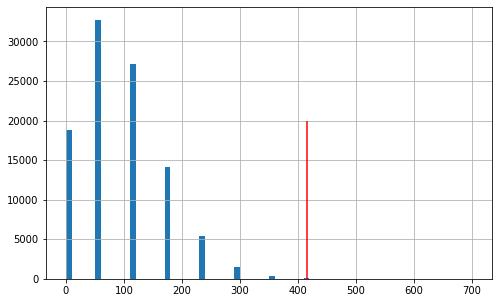

In [3]:
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve, generate_swap_dates
from scipy.stats import uniform

bonds = 20
S = [1-0.08 for _ in range(bonds)]
N = [100 for _ in range(20)]
R = 0.4
r = 0.01
obs_date = date.today()

pillars = [obs_date+relativedelta(years=i) for i in range(2)]
dfs = [1/(1+r)**i for i in range(2)]
dc = DiscountCurve(obs_date, pillars, dfs)
ccs = []
for i in range(bonds):
    ccs.append(CreditCurve(pillars, [1, S[i]]))

scenarios = 100000
losses = []
for _ in range(scenarios):
    loss = 0
    unif = uniform.rvs(size=bonds)
    for i in range(bonds):
        if unif[i] > ccs[i].ndp(pillars[-1]):
            loss += (1 - R)*N[i]*dc.df(pillars[-1]) 
    losses.append(loss)

In [17]:
import numpy as np

print (np.percentile(losses, [99.9]))

[415.84158416]


<img src="credit_var_zcb.png">

Should be now clear that all the consideration done previously on correlated defaults have an impact also here.

### Credit VaR and One Factor Copula Model

Consider a portfolio made of similar assets. As an approximation assume that the probability of default is the same for each counter-party and that the correlation between each pair is the same and equal to $\rho$. 

If we use the One Factor Copula model to describe the default correlations

$$ DP=\Phi\left(\cfrac{\Phi^{-1}[Q(T)]-M\sqrt{\rho}}{\sqrt{1-\rho}}\right)$$

gives us the percentage of defaults by time $T$ given the parameter $M$. 
Indeed if you a have $n$ counter-parties with the same default probability $DP(t)$ the **percentage of defaults** at time $t$ is $DP$ itself

$$\textrm{% of defaults} = \textrm{nDefaults}/n = (n\cdot DP)/n$$

Since $M$ is distributed according to a standard normal we can be $X\%$ certain that its value will be greater than $\Phi^{-1}(1−X) = -\Phi^{-1}(X)$, where the last equality holds due to the symmetry of the Gaussian distribution.

<img src="certain_for_X.png">

But once $T$ has been fixed the only random variable in $DP$ is $M$, therefore we can say that we are $X\%$ certain that the percentage of losses over $T$ years on a large portfolio will be less than $V(X, T)$ where

$$ V(X, T)=\Phi\left(\cfrac{\Phi^{-1}[Q(T)]+\Phi^{-1}(X)\sqrt{\rho}}{\sqrt{1-\rho}}\right)$$

When $X\%$ confidence level is used and the time horizon is $T$, a rough estimate of the Credit VaR is therefore $P ( 1 − R ) V ( X, T )$ , where $P$ is the size of the portfolio and $R$ is the recovery rate.

Suppose that a bank has a total of €100 million of retail exposures. 
The 1-year probability of default averages to 2% and the recovery rate averages to 60%. The copula correlation parameter is estimated as 0.1.

In [18]:
from scipy.stats import norm
from math import sqrt

X = 0.999
rho = 0.1
R = 0.6
DP = 0.02
exposure = 100e6

num = norm.ppf(DP) + sqrt(rho)*norm.ppf(X)
den = sqrt(1-rho)
V = norm.cdf(num/den)
cr_var = exposure*V*(1-R)

print ("Cr-VaR: {:.0f}".format(round(cr_var, -4)))

Cr-VaR: 5130000


### CreditMetrics

Another popular approach to compute Credti VaR is CreditMetrics. It involves estimating a probability distribution of credit losses by carrying out Monte Carlo simulations of the credit rating changes of all counter-parties.

Imagine we would like to determine the probability distribution of losses over 1-year period.
On each simulation, the credit rating changes and default of each counter-party is computed.

The portfolio value is than computed to determine the eventual losses.

<img src="credit_metrics_table.png">

Clearly credit rate changes cannot be assumed independent, hence a copula approach can be
implemented also here. As an example suppose to simulate rating change of a portfolio of 9 bonds with various ratings over 1-year period. The correlation between them is 0.2.

In [56]:
from scipy.stats import multivariate_normal, norm
import numpy

# AAA, AA, A, BBB, BB, B, CCC, Def
table = [[90.81, 8.33, 0.68, 0.06, 0.08, 0.02, 0.01, 0.01],
         [0.70, 90.65, 7.79, 0.64, 0.06, 0.13, 0.02, 0.01],
         [0.09, 2.27, 91.05, 5.52, 0.74, 0.26, 0.01, 0.06],
         [0.02, 0.33, 5.95, 85.93, 5.30, 1.17, 1.12, 0.18],
         [0.03, 0.14, 0.67, 7.73, 80.53, 8.84, 1.00, 1.06],
         [0.01, 0.11, 0.24, 0.43, 6.48, 83.46, 4.07, 5.20],
         [0.21, 0, 0.22, 1.30, 2.38, 11.24, 64.86, 19.79]]

#able_gauss = []
#for i in range(len(table)):
#    temp = []
#    s = 0
#    for j in range(8):
#        s += table[i][j]/100
#        if s>1:
#            s = 1
#        temp.append(norm.ppf(s))
#    table_gauss.append(temp)

t = numpy.array(table)
table_gauss = norm.ppf(np.cumsum(t/100., axis=1))
table_gauss[:, -1] = np.inf

N = [100, 95, 92, 85, 80, 70, 60]
portfolio = [2, 3, 3, 4, 5, 6, 3, 4, 2]
R = 0.4

p0 = 0
for i in portfolio:
    p0 += N[i]

numpy.random.seed(1)
mvnorm = multivariate_normal(mean=[0 for _ in range(9)],
                             cov=[[1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1, 0.2],
                                  [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 1]])

trials = 1000000
x_prob = mvnorm.rvs(size=trials)

dp = []
for x in x_prob:
    p = 0
    for j in range(len(portfolio)):
        ip = 0
        while x[j] > table_gauss[portfolio[j], ip]:
            ip += 1
        if ip == 7:
            p += N[portfolio[j]]*(1-R)
        else:
            p += N[ip]

    r = max(0, -(p - p0))
    if r != 0:
        dp.append(r)
        
crvar = numpy.percentile(dp, [99.9])
print (crvar)

[126.]


<img src="credit_metrics.png">

### Credit Valuation Adjustment

Suppose you have a portfolio of derivatives with a counter-party. If the counter-party defaults and the present value of the portfolio at default is positive to the surviving party, then the surviving party only gets a recovery fraction of the portfolio value from the defaulted entity. 

If however the present value is negative to the surviving party, it has to pay it in full to the liquidators of the defaulted entity. This creates and asymmetry that, once one has done all calculations, says that the value of the deal under counter-party risk is the value without counter-party risk minus a positive adjustment, called Credit Valuation Adjustment (CVA).

It can be expressed in the following way:

$$\textrm{CVA} = ( 1 − R )\int^{T}_{0} D(t)\cdot EE(t) dP(t) $$

where $T$ is the latest maturity in the portfolio, $D$ is the discount factor, $EE$ is the expected exposure or $\mathbb{E}[ \textrm{max(0, NPV portfolio)}]$. 

For an easier computation it is natural to discretize the above integral and use a time grid going from 0 to the maturity of the portfolio:

$$\textrm{CVA} = ( 1 − R ) \sum_i D(t_i)\cdot EE(t_i) P(t_{i − 1}, t_i)$$

Let us say that Credit VaR measures the risk of losses you face due to the possible default of some counter-parties you are having business with. CVA measures the pricing component of this risk, i.e. the adjustment to the price of a product due to this risk.

### Debit Valuation Adjustment

The adjustment seen from the point of view of our counter-party is positive, and is called Debit Valuation Adjustment, DVA. It is positive because the early default of the client itself would imply a discount on the client payment obligations, and this means a gain in a way. So the client marks a positive adjustment over the risk free price by adding the positive amount called DVA.

Basically when both parties have the possibility to default, they consistently include both defaults into the valuation. Hence every party needs to include its own default besides the default of the counter-party into the valuation. So they will mark a positive CVA to be subtracted and a positive DVA to be added to the default risk free price of the deal. The CVA of one party will be the DVA of the other one and viceversa.

$$\textrm{price = default risk free price + DVA - CVA}$$

Now, since
$$\textrm{default risk free price(A) = − default risk free price(A)}$$
$$\textrm{DVA(A) = CVA(B)}$$
$$\textrm{DVA(B) = CVA(A)}$$

we get that eventually
$$\textrm{price(A) = − price(B)}$$

so that both parties agree on the price, or, we could say, there is money conservation.

### CVA Computation
The computation of the CVA is easily carried on with Monte Carlo simulation. First simulate the development of your derivatives portfolio (its NPV) at each time point for each MC scenario. Then calculate the CVA using Eone of the previous definitions. Finally average the CVA of all the scenarios to get its best estimate.

In case of bonds the computation of the CVA can be further simplified. Indeed in this case the exposure of the investor is equal to the notional of the bond, so it is enough to loop through each days from the observation date to the maturity of the bond and compute the CVA. 

Imagine a 3-years bond with a notional N = €100. The bond provides yearly coupons of 6%.
The bond issuer has the following default probabilities 10%, 20% and 30% for 1, 2 and 3 years respectively (the recovery rate is 40%). The risk free rate is 3%.

To compute CVA we need to first define a discount curve and the credit curve corresponding
to the issuer.

In [67]:
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve
import math

T = 3 
r = 0.03
R = 0.4
N = 100

obs_date = date.today()
pillars = [obs_date+relativedelta(years=i) for i in range(T+1)]
dfs = [math.exp(-r*i) for i in range(T+1)]
dc = DiscountCurve(obs_date, pillars, dfs)
S = [1, 0.9, 0.8, 0.7]
cc = CreditCurve(pillars, S)
V = N * math.exp(-r*i)

cva = 0
d = obs_date
while d <= pillars[-1]:
    cva += dc.df(d)*(cc.ndp(d) - cc.ndp(d+relativedelta(days=1)))
    d += relativedelta(days=1)

cva *= (1-R) * N
print ("CVA: {:.2f}".format(cva))
print ("Bond Price: {:.2f}".format(V - cva))

CVA: 17.21
Bond Price: 74.18


If we assume that the recovery payments are done at the maturity date of the zero coupon bond the formula CVA calculation can be simplified further, indeed

$$ \textrm{CVA} = (1-R)\cdot N \cdot \sum_{i=1}^{n} D(d_i)\cdot Q(d_{i-1}, d_i) $$
becomes
$$ \textrm{CVA} = (1-R)\cdot N\cdot D(d_n)\cdot\sum_{i=1}^{n} Q(d_{i-1}, d_i) = (1-R)\cdot N\cdot Q(d_{0}, d_n)$$


In [66]:
print (N*dc.df(pillars[-1])*(1-R)*0.3)

16.450761334882106
